### Import Pacakges

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.metrics import classification_report
import optuna

/home/dawei/data-science/network-traffic-threat-detection/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

### Load Data

We combine the data in Training and Testing Sets directory instead of directly using the full dataset

In [3]:
dataset_1 = pd.read_csv('./CSV Files/UNSW-NB15_1.csv')
dataset_2 = pd.read_csv('./CSV Files/UNSW-NB15_2.csv')
dataset_3 = pd.read_csv('./CSV Files/UNSW-NB15_3.csv')
dataset_4 = pd.read_csv('./CSV Files/UNSW-NB15_4.csv')

description = pd.read_csv('./CSV Files/NUSW-NB15_features.csv', encoding='cp1252')

description

dataset_1.columns = description['Name'] 
dataset_2.columns = description['Name'] 
dataset_3.columns = description['Name'] 
dataset_4.columns = description['Name'] 


df = pd.concat([dataset_1, dataset_2, dataset_3, dataset_4])
df = df.sample(frac=1).reset_index(drop=True)

df.info()

/tmp/ipykernel_5032/564811893.py:1: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_1 = pd.read_csv('./CSV Files/UNSW-NB15_1.csv')
/tmp/ipykernel_5032/564811893.py:2: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_2 = pd.read_csv('./CSV Files/UNSW-NB15_2.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540043 entries, 0 to 2540042
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  Sload             float64
 15  Dload             float64
 16  Spkts             int64  
 17  Dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  Sjit          

In [4]:
description['Type']

0       nominal
1       integer
2       nominal
3       integer
4       nominal
5       nominal
6         Float
7       Integer
8       Integer
9       Integer
10      Integer
11      Integer
12      Integer
13      nominal
14        Float
15        Float
16      integer
17      integer
18      integer
19      integer
20      integer
21      integer
22      integer
23      integer
24      integer
25      integer
26        Float
27        Float
28    Timestamp
29    Timestamp
30        Float
31        Float
32        Float
33        Float
34        Float
35       Binary
36      Integer
37      Integer
38       Binary
39      integer
40      integer
41      integer
42      integer
43      integer
44      integer
45      integer
46      integer
47      nominal
48       binary
Name: Type, dtype: object

### Data Preprocessing

#### Check duplicated rows

In [5]:
duplicate_count = df.duplicated().sum()

duplicate_percentage = (duplicate_count / len(df)) * 100

print(f"Number of duplicate rows: {duplicate_count}")
print(f"Percentage of duplicate rows: {duplicate_percentage:.2f}%")


Number of duplicate rows: 480626
Percentage of duplicate rows: 18.92%


In [6]:
df = df.drop_duplicates()

#### Check missing value

In [7]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
})

missing_columns = missing_info[missing_info['Missing Values'] > 0]

if len(missing_columns) > 0:
    print("Columns with missing values:")
    print(missing_columns)
else:
    print("No missing values found in the dataset.")
    
# Get overall summary of missing values
print("\nTotal missing values:", df.isnull().sum().sum())
print("Percentage of missing data:", (df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100, "%")


Columns with missing values:
                  Missing Values  Percentage (%)
Name                                            
ct_flw_http_mthd          933603       45.333364
is_ftp_login             1014165       49.245248
attack_cat               1959771       95.161446

Total missing values: 3907539
Percentage of missing data: 3.8722460714634783 %


In [8]:
# Fill missing values in is_ftp_login with 0 because 0 means no FTP login
df['is_ftp_login'] = df['is_ftp_login'].fillna(0)
# Fill missing values in ct_flw_http_mthd with 0 because 0 means no HTTP method
df['ct_flw_http_mthd'] = df['ct_flw_http_mthd'].fillna(0)

# We drop the 'attack_cat' column as it is not needed for the analysis
df = df.drop('attack_cat', axis=1)

#### Check NaN values

In [9]:
# Check for NaN values in each column
nan_values = df.isna().sum()
nan_percentage = (nan_values / len(df)) * 100

nan_info = pd.DataFrame({
    'NaN Values': nan_values,
    'Percentage (%)': nan_percentage
})

nan_columns = nan_info[nan_info['NaN Values'] > 0]

if len(nan_columns) > 0:
    print("Columns with NaN values:")
    print(nan_columns)
else:
    print("No NaN values found in the dataset.")
    
# Get overall summary of NaN values
print("\nTotal NaN values:", df.isna().sum().sum())
print("Percentage of NaN data:", (df.isna().sum().sum() / (df.shape[0] * df.shape[1])) * 100, "%")

# Check for infinite values
inf_count = np.isinf(df.select_dtypes(include=['float64', 'int64'])).sum().sum()
print(f"\nNumber of infinite values: {inf_count}")


No NaN values found in the dataset.

Total NaN values: 0
Percentage of NaN data: 0.0 %

Number of infinite values: 0


#### Check inconsistant type in columns

In [10]:
def check_df_type():
    # Create a comparison DataFrame
    type_comparison = pd.DataFrame({
        'Column': df.columns,
        'Current Type': df.dtypes
    })

    # Merge with description to get expected types
    type_comparison = type_comparison.merge(
        description[['Name', 'Type']],
        left_on='Column',
        right_on='Name',
        how='left'
    ).drop('Name', axis=1)

    # Add a column to show if types match
    def check_type_match(current, expected):
        if pd.isna(expected):
            return 'N/A'
        if expected.lower() == 'nominal' and current == 'object':
            return '✓'
        elif expected.lower() == 'integer' and current in ['int64', 'Int64']:
            return '✓'
        elif expected.lower() == 'float' and current == 'float64':
            return '✓'
        elif expected.lower() == 'binary' and current in ['int64', 'Int64']:
            return '✓'
        elif expected.lower() == 'timestamp' and current in ['int64', 'Int64']:
            return '✓'
        else:
            return '✗'

    type_comparison['Match'] = type_comparison.apply(
        lambda x: check_type_match(str(x['Current Type']), x['Type']), axis=1
    )

    # Show only mismatched types
    mismatches = type_comparison[type_comparison['Match'] == '✗']
    print("Columns with type mismatches:")
    print(mismatches.to_string(index=False))

    # Show the full type comparison
    print("\nFull type comparison:")
    print(type_comparison.to_string(index=False))


In [11]:
check_df_type()

Columns with type mismatches:
          Column Current Type    Type Match
           sport       object integer     ✗
          dsport       object integer     ✗
ct_flw_http_mthd      float64 Integer     ✗
    is_ftp_login      float64  Binary     ✗
      ct_ftp_cmd       object integer     ✗

Full type comparison:
          Column Current Type      Type Match
           srcip       object   nominal     ✓
           sport       object   integer     ✗
           dstip       object   nominal     ✓
          dsport       object   integer     ✗
           proto       object   nominal     ✓
           state       object   nominal     ✓
             dur      float64     Float     ✓
          sbytes        int64   Integer     ✓
          dbytes        int64   Integer     ✓
            sttl        int64   Integer     ✓
            dttl        int64   Integer     ✓
           sloss        int64   Integer     ✓
           dloss        int64   Integer     ✓
         service       object   nominal

In [12]:
df['sport'] = df['sport'].astype('str')
df['sport'] = pd.to_numeric(df['sport'], errors='coerce').fillna(0).astype(int)

df['dsport'] = df['dsport'].astype('str')
df['dsport'] = pd.to_numeric(df['dsport'], errors='coerce').fillna(0).astype(int)

df['ct_flw_http_mthd'] = df['ct_flw_http_mthd'].astype('int64')


In [13]:
df['ct_ftp_cmd'].unique()

array([' ', 0, 3, '0', '1', 4, 1, 2, 5, '4', 6, 8, '2'], dtype=object)

In [14]:
df['ct_ftp_cmd'] = df['ct_ftp_cmd'].replace(' ', '0')

df['ct_ftp_cmd'] = pd.to_numeric(df['ct_ftp_cmd'], errors='coerce').fillna(0).astype(int)

In [15]:
df['is_ftp_login'] = (df['is_ftp_login'] > 0).astype(int)

In [16]:
check_df_type()

Columns with type mismatches:
Empty DataFrame
Columns: [Column, Current Type, Type, Match]
Index: []

Full type comparison:
          Column Current Type      Type Match
           srcip       object   nominal     ✓
           sport        int64   integer     ✓
           dstip       object   nominal     ✓
          dsport        int64   integer     ✓
           proto       object   nominal     ✓
           state       object   nominal     ✓
             dur      float64     Float     ✓
          sbytes        int64   Integer     ✓
          dbytes        int64   Integer     ✓
            sttl        int64   Integer     ✓
            dttl        int64   Integer     ✓
           sloss        int64   Integer     ✓
           dloss        int64   Integer     ✓
         service       object   nominal     ✓
           Sload      float64     Float     ✓
           Dload      float64     Float     ✓
           Spkts        int64   integer     ✓
           Dpkts        int64   integer     ✓
  

#### Drop useless columns

In [17]:
columns_to_drop = ['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'service', 'Stime', 'Ltime']
df = df.drop(columns=columns_to_drop)

### Data Analysis

In [18]:
y = df['Label']
X = df.drop('Label', axis=1)

#### Check outliors 

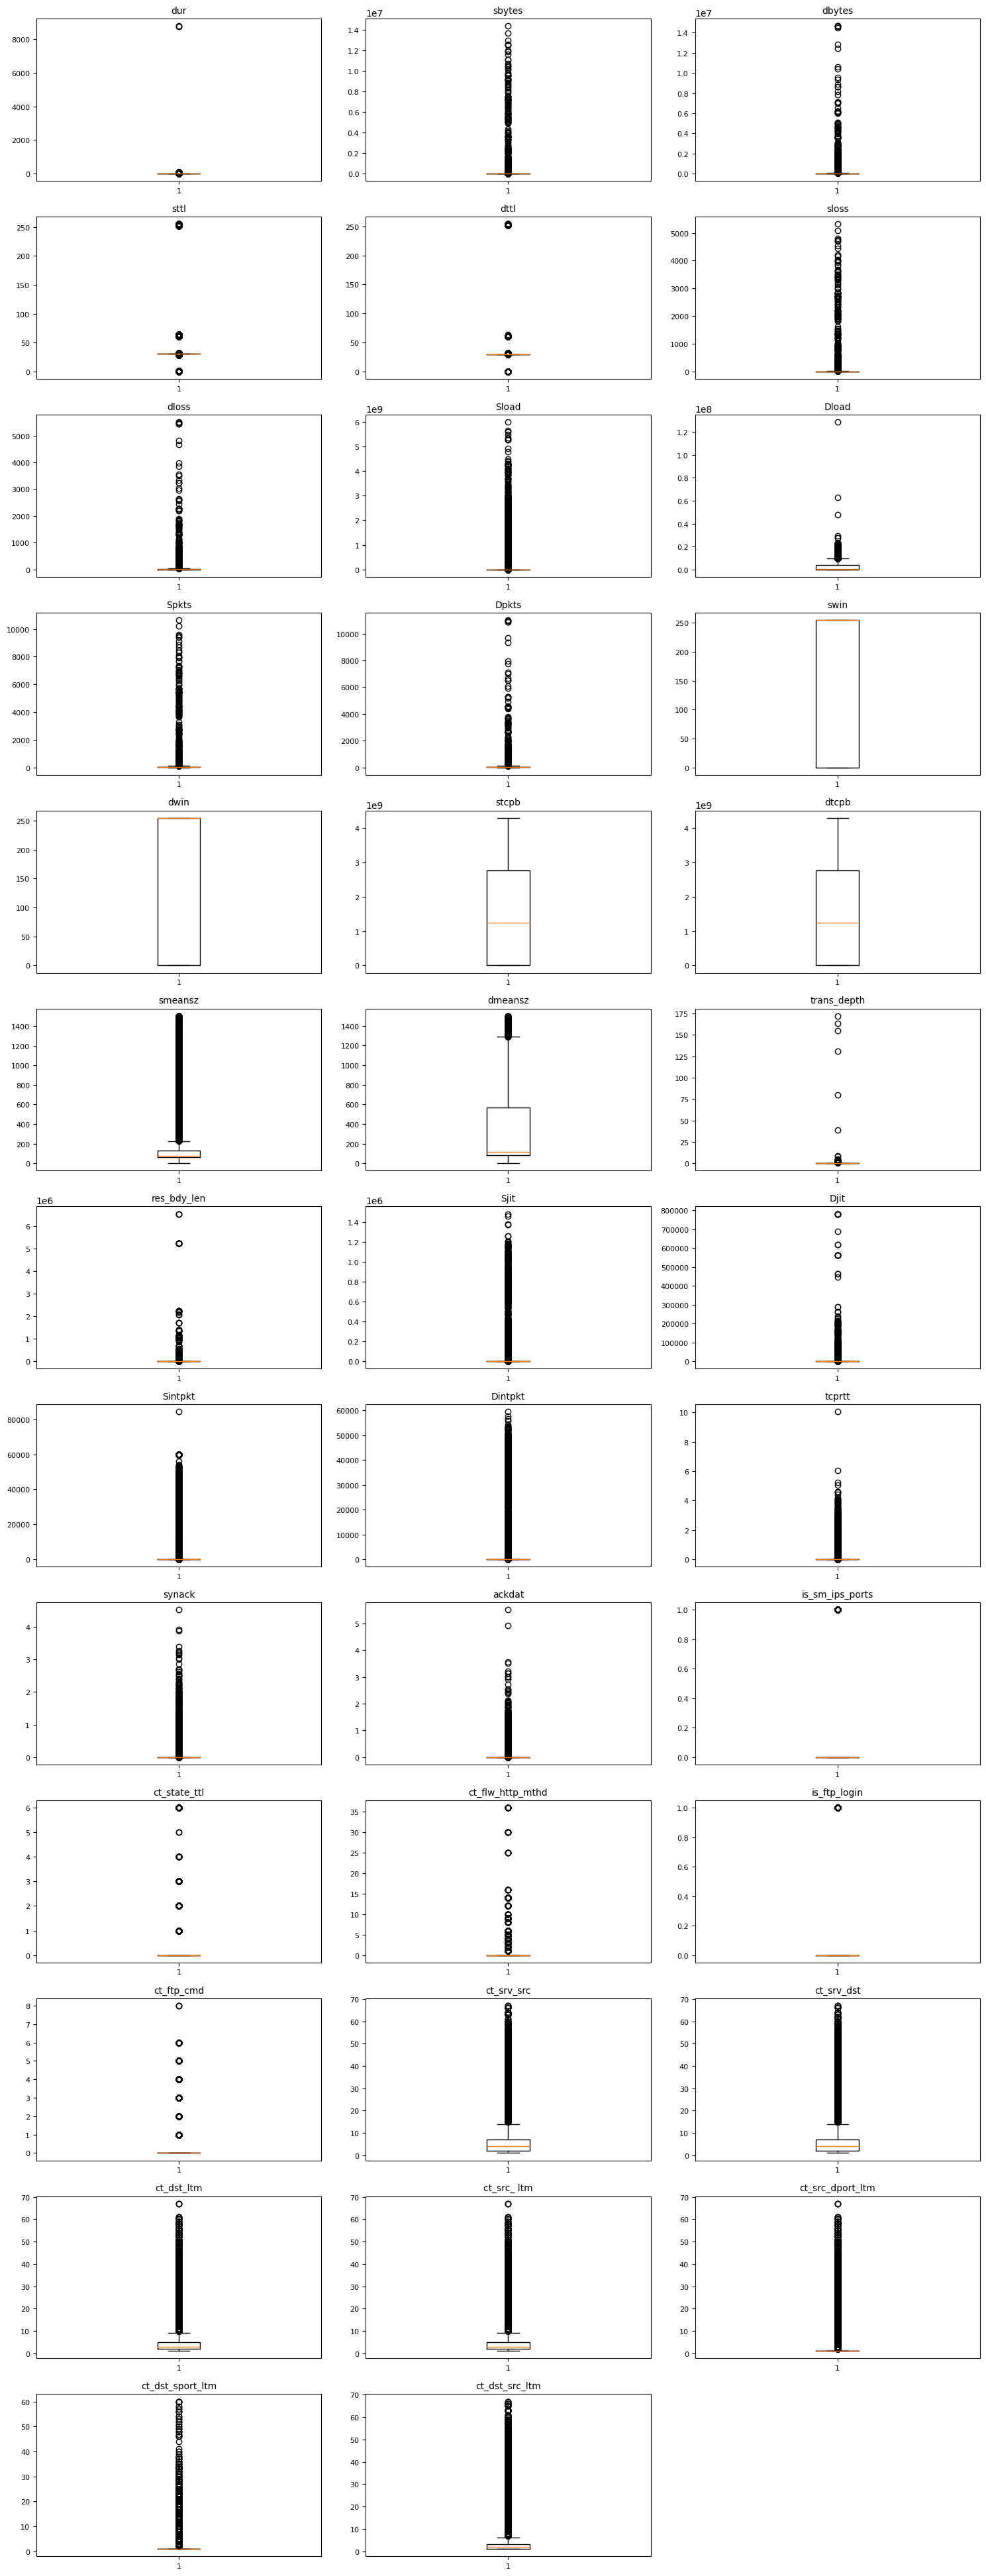

In [19]:
num_cols = X.columns.tolist()

n = len(num_cols)
n_cols = 3                     
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*3))
axes = axes.flatten()

for ax, col in zip(axes, num_cols):
    ax.boxplot(X[col].dropna())
    ax.set_title(col, fontsize=10)
    ax.tick_params(labelsize=8)

for ax in axes[len(num_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

#### Check target distribution

Class Distribution:
Label
0    1959771
1      99646
Name: count, dtype: int64

Percentage Distribution:
Label
0    95.161446
1     4.838554
Name: count, dtype: float64


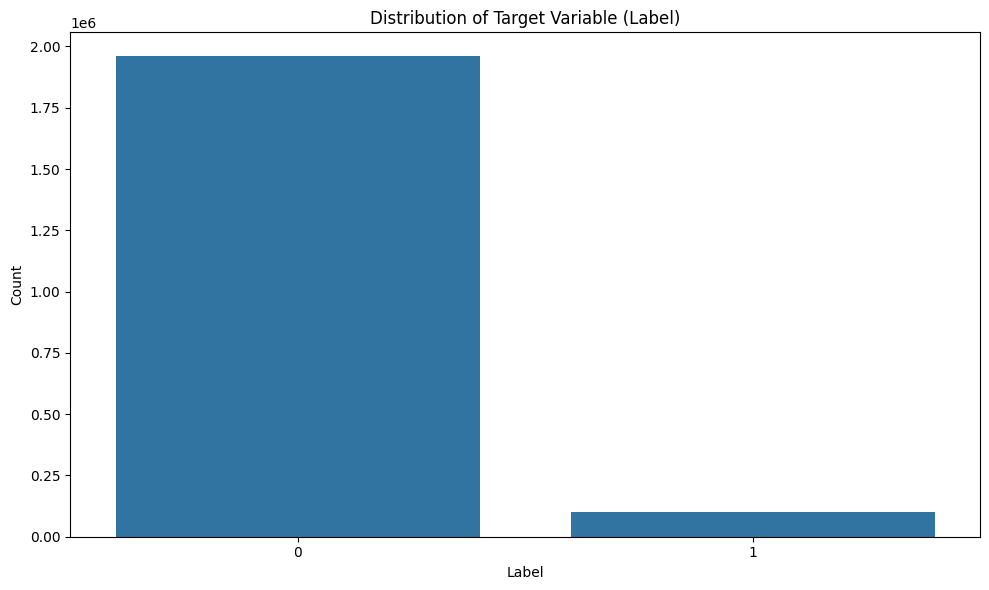

In [20]:
# Count the distribution of the target variable 'Label'
label_counts = y.value_counts()

# Display the counts
print("Class Distribution:")
print(label_counts)
print("\nPercentage Distribution:")
print(label_counts / len(y) * 100)

# Create a bar plot to visualize the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Target Variable (Label)')
plt.xlabel('Label')
plt.ylabel('Count')
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Feature Correlation

<Axes: title={'center': 'FeatureCorrelation Plot'}, xlabel='Name', ylabel='Name'>

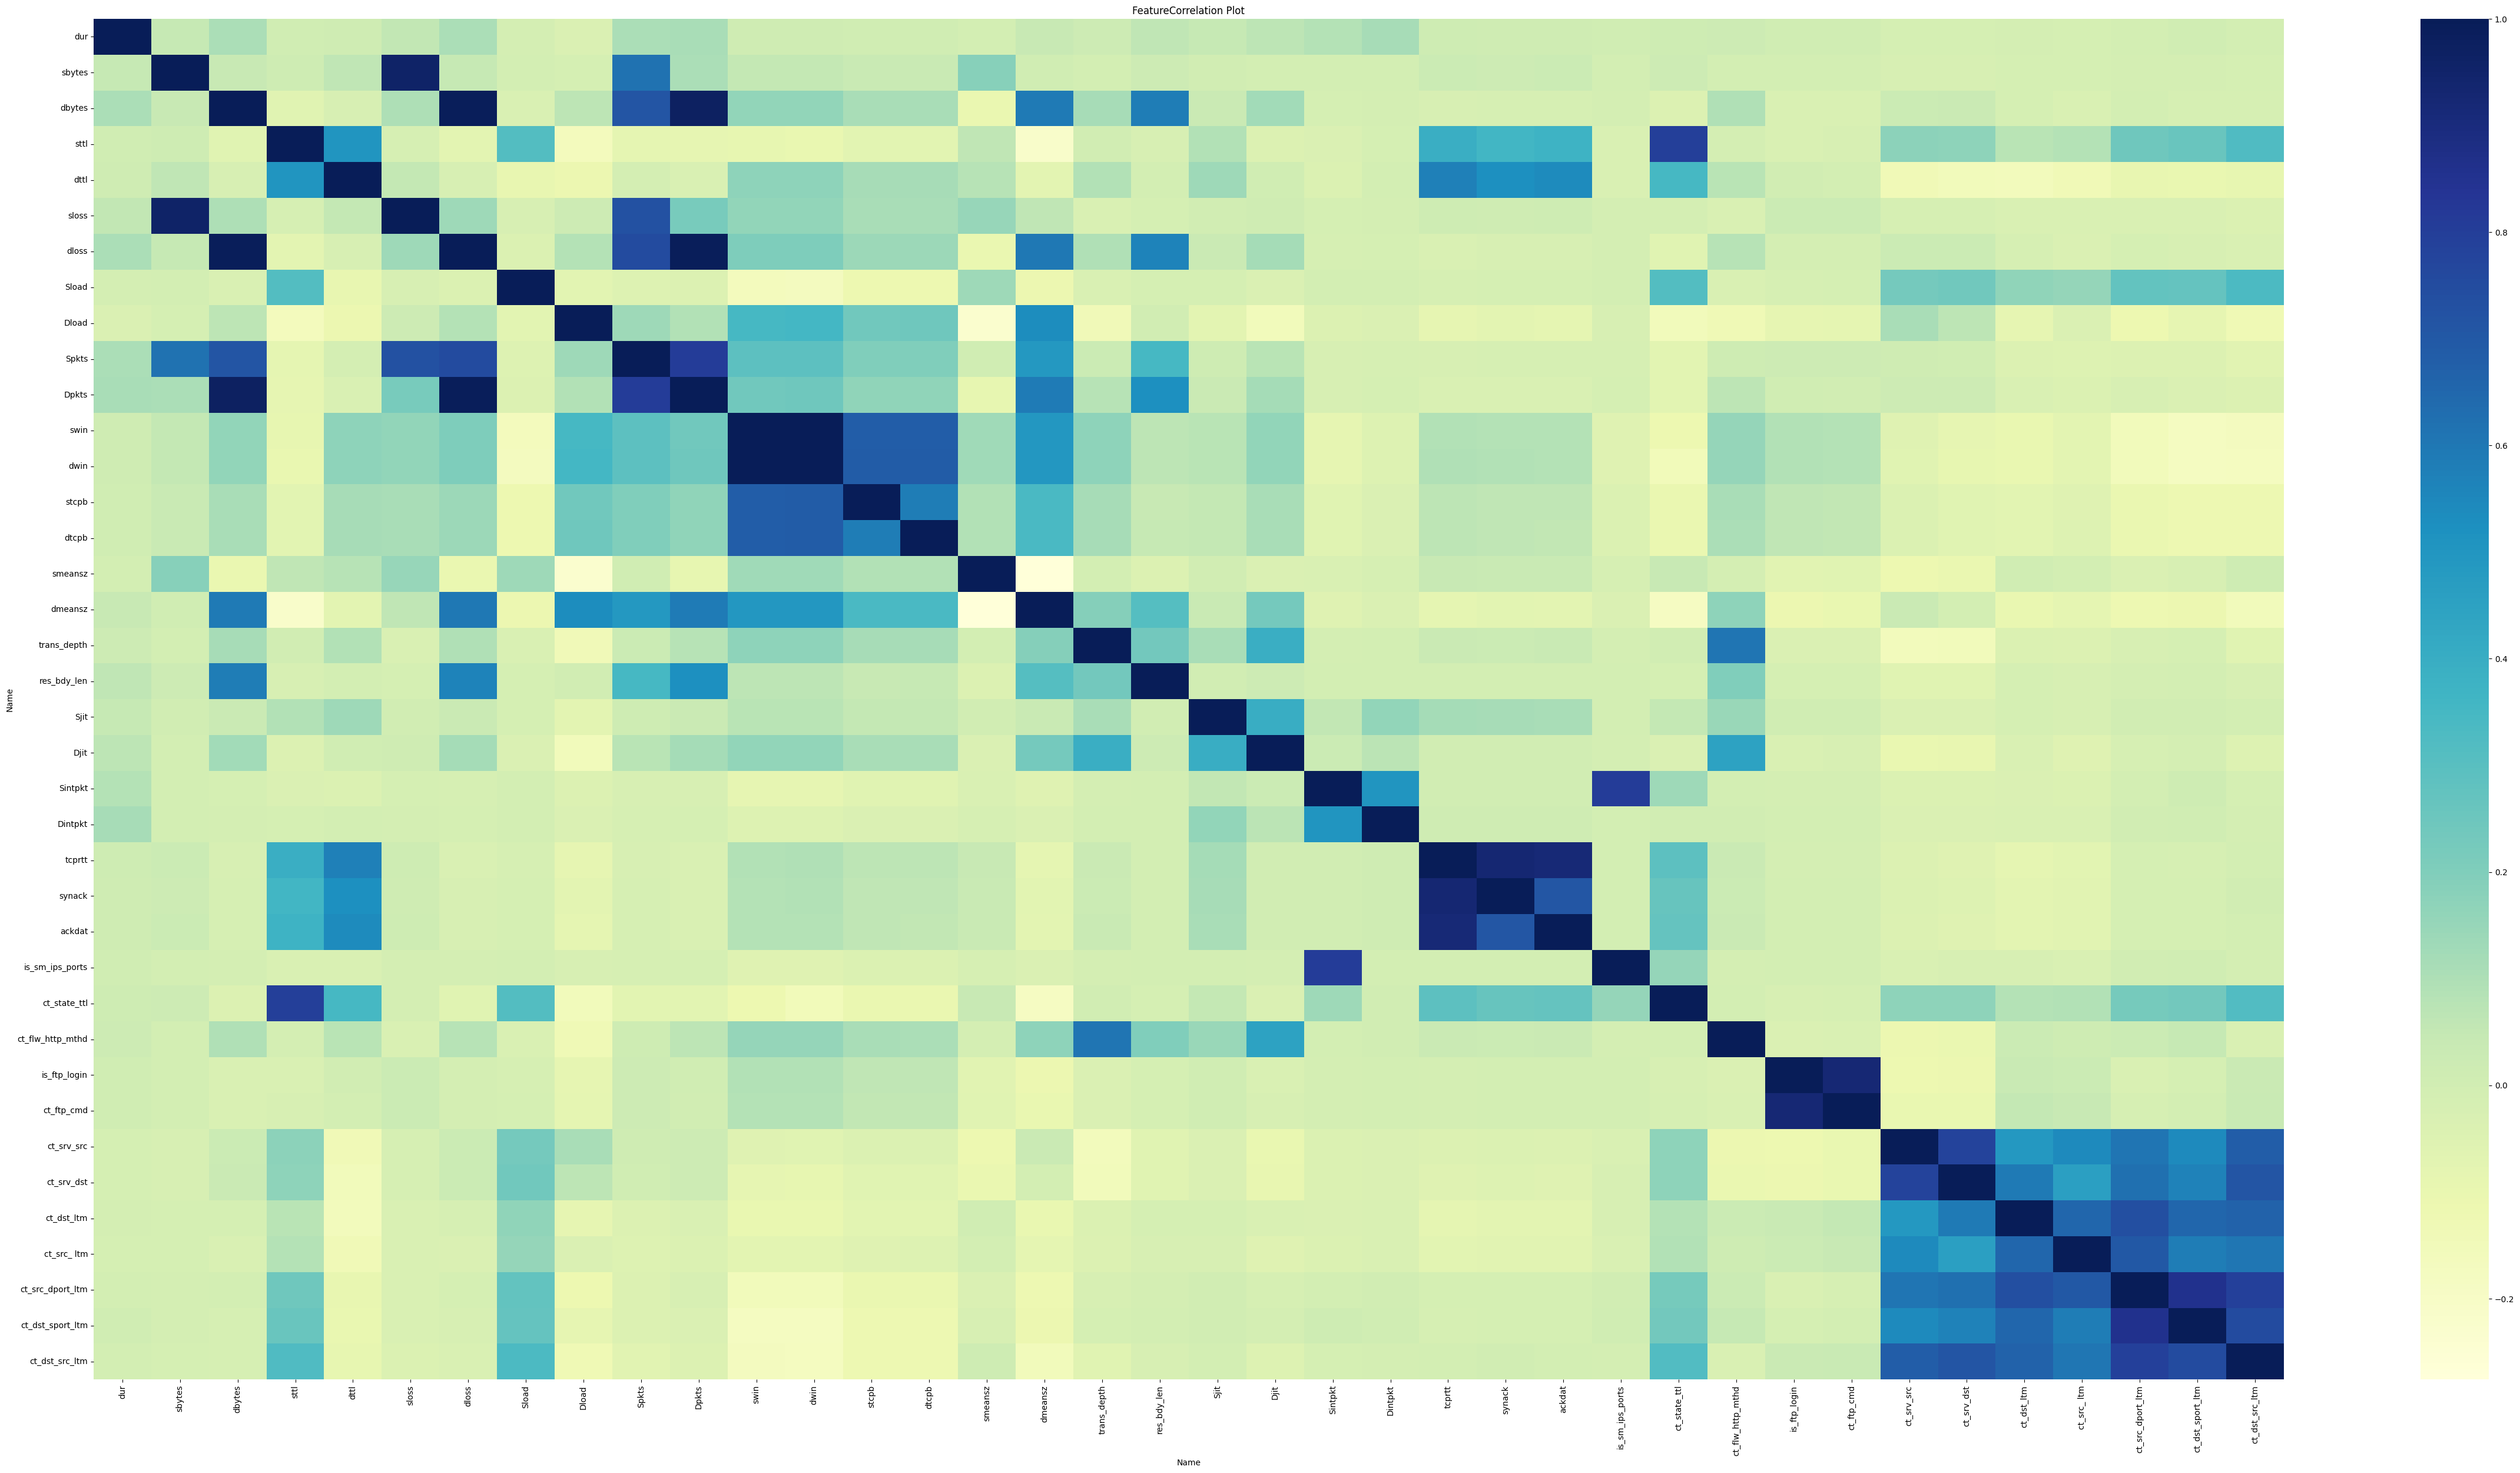

In [21]:
plt.figure(figsize=(60,30))
plt.title("FeatureCorrelation Plot")
sns.heatmap(X.corr(),cmap='YlGnBu')

#### Feature Distribution
# Create a figure with subplots for each numeric column



Highly correlated features (threshold = 0.7):
------------------------------------------------------------
Feature 1            Feature 2            Correlation
------------------------------------------------------------
swin                 dwin                 0.9965
dloss                Dpkts                0.9922
dbytes               dloss                0.9916
dbytes               Dpkts                0.9718
sbytes               sloss                0.9594
tcprtt               synack               0.9302
is_ftp_login         ct_ftp_cmd           0.9240
tcprtt               ackdat               0.9178
ct_src_dport_ltm     ct_dst_sport_ltm     0.8557
Spkts                Dpkts                0.8088
Sintpkt              is_sm_ips_ports      0.8071
sttl                 ct_state_ttl         0.7960
ct_src_dport_ltm     ct_dst_src_ltm       0.7928
ct_srv_src           ct_srv_dst           0.7851
dloss                Spkts                0.7513
ct_dst_sport_ltm     ct_dst_src_ltm       0

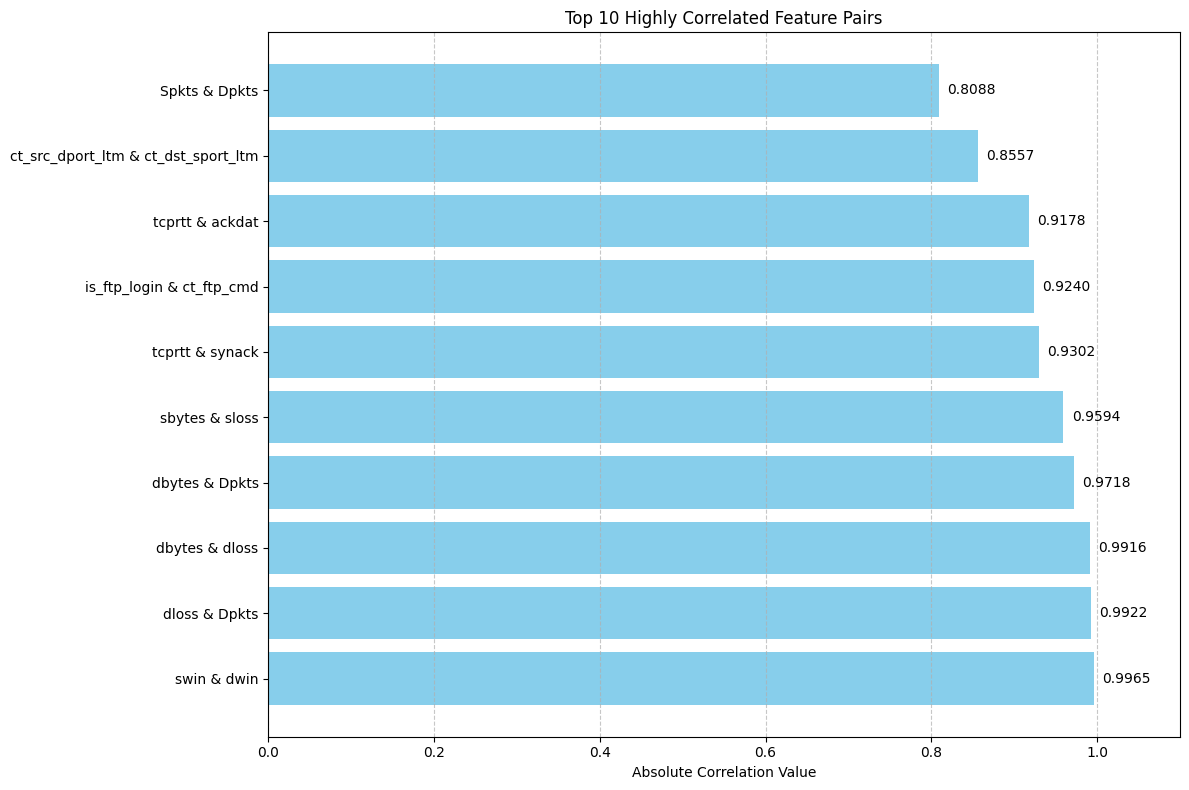

In [22]:
# Calculate the correlation matrix
correlation_matrix = X.corr()

# Set a correlation threshold to identify highly correlated features
threshold = 0.7

# Find feature pairs with correlation above the threshold
high_corr_pairs = []

# Loop through the correlation matrix to find highly correlated pairs
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                correlation_matrix.iloc[i, j]
            ))

# Sort by correlation value (absolute) in descending order
high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

# Print the highly correlated feature pairs
print(f"Highly correlated features (threshold = {threshold}):")
print("-" * 60)
print(f"{'Feature 1':<20} {'Feature 2':<20} {'Correlation':<10}")
print("-" * 60)

for feat1, feat2, corr in high_corr_pairs:
    print(f"{feat1:<20} {feat2:<20} {corr:.4f}")

# Create a visualization of the top N highly correlated pairs
if high_corr_pairs:
    top_n = min(10, len(high_corr_pairs))  # Show top 10 or all if less than 10
    
    plt.figure(figsize=(12, 8))
    
    # Extract data for plotting
    features1 = [pair[0] for pair in high_corr_pairs[:top_n]]
    features2 = [pair[1] for pair in high_corr_pairs[:top_n]]
    corr_values = [pair[2] for pair in high_corr_pairs[:top_n]]
    
    # Create bar chart
    bars = plt.barh(range(len(corr_values)), [abs(c) for c in corr_values], color='skyblue')
    
    # Add correlation values to the end of each bar
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                 f'{corr_values[i]:.4f}', va='center')
    
    # Set labels and title
    plt.yticks(range(len(corr_values)), [f"{f1} & {f2}" for f1, f2 in zip(features1, features2)])
    plt.xlabel('Absolute Correlation Value')
    plt.title(f'Top {top_n} Highly Correlated Feature Pairs')
    plt.xlim(0, 1.1)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No feature pairs found with correlation above the threshold.")


In [23]:
# Create a set to keep track of features to drop
features_to_drop = set()

# Identify features to drop based on correlation
for feat1, feat2, corr in high_corr_pairs:
    if feat1 not in features_to_drop and feat2 not in features_to_drop:
        features_to_drop.add(feat2)

# Print features that will be dropped
print(f"Features to be dropped ({len(features_to_drop)}):")
for feature in features_to_drop:
    print(f"- {feature}")

# Create a new dataframe without the highly correlated features
if features_to_drop:
    X_reduced = X.drop(columns=list(features_to_drop))
    print(f"\nDataset shape before dropping features: {X.shape}")
    print(f"Dataset shape after dropping features: {X_reduced.shape}")
    
    # Update our working dataframe
    X = X_reduced
else:
    print("No features were dropped as none met the correlation threshold criteria.")


Features to be dropped (14):
- ct_srv_dst
- Spkts
- ct_dst_sport_ltm
- dwin
- dloss
- ct_ftp_cmd
- is_sm_ips_ports
- Dpkts
- ct_src_dport_ltm
- ackdat
- ct_dst_src_ltm
- synack
- ct_state_ttl
- sloss



Dataset shape before dropping features: (2059417, 38)
Dataset shape after dropping features: (2059417, 24)


In [24]:
print("Columns after dropping highly correlated features:")
print(X.columns)

Columns after dropping highly correlated features:
Index(['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'Sload', 'Dload', 'swin',
       'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len',
       'Sjit', 'Djit', 'Sintpkt', 'Dintpkt', 'tcprtt', 'ct_flw_http_mthd',
       'is_ftp_login', 'ct_srv_src', 'ct_dst_ltm', 'ct_src_ ltm'],
      dtype='object', name='Name')


#### Split data into training and testing set for baseline model

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (1441591, 24)
Testing set shape: (617826, 24)


#### Standard Scale

In [26]:
from sklearn.discriminant_analysis import StandardScaler


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#### PCA

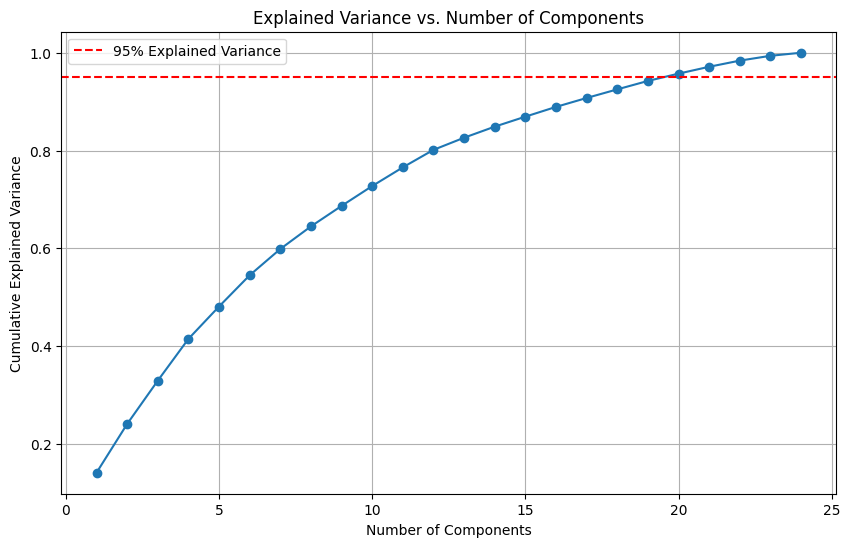

Number of components needed for 95% variance: 20
Original feature shape: (1441591, 24)
PCA reduced feature shape: (1441591, 20)


In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Initialize PCA
pca = PCA()

# Fit PCA on training data
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend()
plt.show()

# Find number of components for 95% variance
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Number of components needed for 95% variance: {n_components}")

# Apply PCA with selected number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print(f"Original feature shape: {X_train.shape}")
print(f"PCA reduced feature shape: {X_train_pca.shape}")

# Update our working datasets
X_train = X_train_pca
X_test = X_test_pca

### Training model

#### Baseline Model - Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=50,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=50, n_jobs=-1,
                       random_state=42)

Random Forest Test Results:

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    587932
           1       0.88      0.89      0.88     29894

    accuracy                           0.99    617826
   macro avg       0.94      0.94      0.94    617826
weighted avg       0.99      0.99      0.99    617826


Confusion Matrix:
[[584435   3497]
 [  3434  26460]]

Test F1 Score (attack): 0.8842


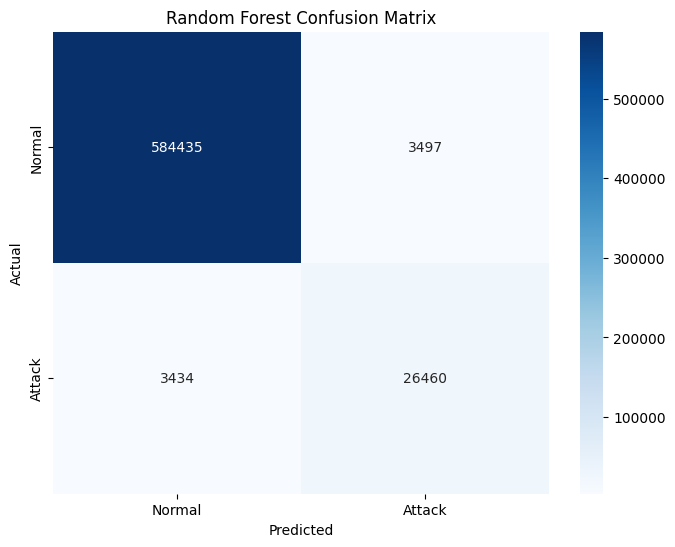

In [29]:
# Make predictions on test data
y_pred_test = rf.predict(X_test)

# Generate classification report
from sklearn.metrics import classification_report, confusion_matrix

print("Random Forest Test Results:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_test)
print(cm)

# Calculate F1 score for the positive class (attack)
test_f1 = f1_score(y_test, y_pred_test, pos_label=1)
print(f"\nTest F1 Score (attack): {test_f1:.4f}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()


In [30]:
def make_loader(X_np, y_np, batch_size=256, shuffle=False):
    X_t = torch.from_numpy(X_np).float()
    y_t = torch.from_numpy(y_np).long()
    ds  = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(X_train, y_train.values, shuffle=True)
test_loader  = make_loader(X_test,  y_test.values)

#### Baseline model - Neural Network

In [31]:
class BaselineNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64]):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=0.3))
            prev = h
        layers.append(nn.Linear(prev, 2))       # 2 output classes
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [32]:
fold_f1_scores = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:

# Instantiate fresh model & optimizer for this fold
model     = BaselineNN(input_dim=X_train.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ── 4. Train for a few epochs ──────────────────────────────────────────────
epochs = 15
for epoch in range(1, epochs+1):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss   = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



Test F1: 0.8843

              precision    recall  f1-score   support

      benign       1.00      0.99      0.99    587932
      attack       0.85      0.92      0.88     29894

    accuracy                           0.99    617826
   macro avg       0.92      0.96      0.94    617826
weighted avg       0.99      0.99      0.99    617826


Confusion Matrix:
[[583187   4745]
 [  2438  27456]]


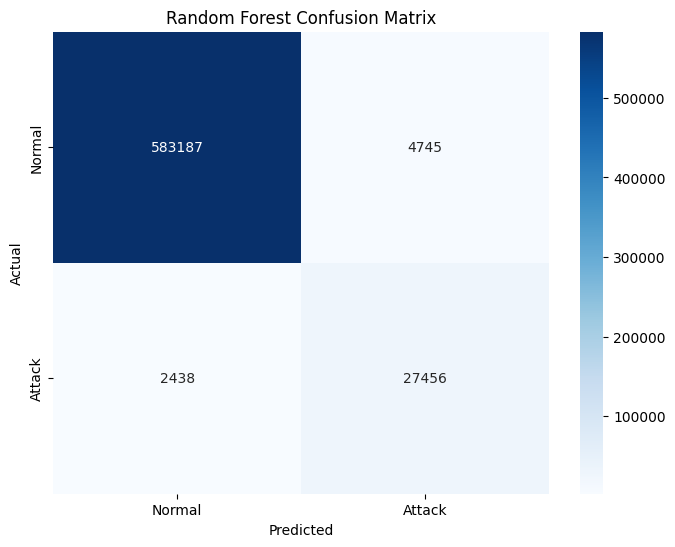

In [34]:
from sklearn.metrics import classification_report


model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(yb.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_labels)
test_f1 = f1_score(y_true, y_pred, pos_label=1)
print(f"\nTest F1: {test_f1:.4f}\n")
print(classification_report(y_true, y_pred, target_names=["benign","attack"]))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

#### Hyperparameter Tuning

##### Reset data

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (1441591, 24)
Testing set shape: (617826, 24)


In [36]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout):
        super().__init__()
        layers, prev = [], input_dim
        for h in hidden_dims:
            layers += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(dropout)]
            prev = h
        layers.append(nn.Linear(prev, 2))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)


In [37]:
def objective(trial):
    # Sample hyperparameters
    n_layers    = trial.suggest_int("n_layers", 1, 4)
    base_units  = trial.suggest_categorical("base_units", [16, 32, 64])
    hidden_dims = [base_units * i for i in range(1, n_layers+1)]
    dropout     = trial.suggest_float("dropout", 0.1, 0.5)
    lr          = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size  = trial.suggest_categorical("bs", [64, 128])

    print(f"Training on {hidden_dims} dims, {dropout} dropout, {lr} lr, {batch_size} batch_size")

    # Stratified K-Fold on the full train+val set
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_scores = []

    for train_idx, val_idx in kf.split(X_train, y_train):
        # Split & scale
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        scaler = StandardScaler().fit(X_tr)
        X_tr_s = scaler.transform(X_tr)
        X_val_s= scaler.transform(X_val)

        # PCA
        pca = PCA(n_components=0.95)
        X_tr_s = pca.fit_transform(X_tr_s)
        X_val_s = pca.transform(X_val_s)

        # DataLoaders
        train_loader = make_loader(X_tr_s, y_tr.values, batch_size, shuffle=True)
        val_loader   = make_loader(X_val_s, y_val.values, batch_size)

        # Model, loss, optimizer
        device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model    = MLP(X_tr_s.shape[1], hidden_dims, dropout).to(device)
        criterion= nn.CrossEntropyLoss()
        optimizer= torch.optim.Adam(model.parameters(), lr=lr)

        # Train a few epochs
        for _ in range(5):  # fewer epochs per trial for speed
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                loss = criterion(model(xb), yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Validate
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                out = model(xb).argmax(dim=1).cpu().numpy()
                preds.append(out); trues.append(yb.numpy())
        preds = np.concatenate(preds)
        trues = np.concatenate(trues)
        fold_scores.append(f1_score(trues, preds, pos_label=1))

    # Return the mean F1 across folds
    return np.mean(fold_scores)

# 5) Run Optuna
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=1))
study.optimize(objective, n_trials=100)



print("Best CV F1:", study.best_value)
print("Best params:", study.best_params)

[I 2025-04-29 08:52:05,820] A new study created in memory with name: no-name-3404d8f7-f2ad-4967-aaad-ac6c4689bbeb


Training on [32, 64, 96, 128] dims, 0.48146354633886623 dropout, 0.00047729544602111786 lr, 64 batch_size


[I 2025-04-29 09:16:04,160] Trial 0 finished with value: 0.8697612196943091 and parameters: {'n_layers': 4, 'base_units': 32, 'dropout': 0.48146354633886623, 'lr': 0.00047729544602111786, 'bs': 64}. Best is trial 0 with value: 0.8697612196943091.


Training on [16] dims, 0.37673337527990247 dropout, 0.005212244282186237 lr, 128 batch_size


[I 2025-04-29 09:24:18,795] Trial 1 finished with value: 0.8707708890472439 and parameters: {'n_layers': 1, 'base_units': 16, 'dropout': 0.37673337527990247, 'lr': 0.005212244282186237, 'bs': 128}. Best is trial 1 with value: 0.8707708890472439.


Training on [16, 32, 48] dims, 0.219686215563081 dropout, 0.0006102488092138396 lr, 64 batch_size


[I 2025-04-29 09:42:31,703] Trial 2 finished with value: 0.8745480957085986 and parameters: {'n_layers': 3, 'base_units': 16, 'dropout': 0.219686215563081, 'lr': 0.0006102488092138396, 'bs': 64}. Best is trial 2 with value: 0.8745480957085986.


Training on [32, 64, 96] dims, 0.20543377664597987 dropout, 0.0008520463664019314 lr, 64 batch_size


[I 2025-04-29 10:00:06,938] Trial 3 finished with value: 0.8691941367981668 and parameters: {'n_layers': 3, 'base_units': 32, 'dropout': 0.20543377664597987, 'lr': 0.0008520463664019314, 'bs': 64}. Best is trial 2 with value: 0.8745480957085986.


Training on [16] dims, 0.1224203157762117 dropout, 0.0037774112339320947 lr, 64 batch_size


[I 2025-04-29 10:14:55,851] Trial 4 finished with value: 0.8745968649941641 and parameters: {'n_layers': 1, 'base_units': 16, 'dropout': 0.1224203157762117, 'lr': 0.0037774112339320947, 'bs': 64}. Best is trial 4 with value: 0.8745968649941641.


Training on [32, 64, 96, 128] dims, 0.3193738518500592 dropout, 0.008568593639434744 lr, 64 batch_size


[I 2025-04-29 10:34:53,602] Trial 5 finished with value: 0.790651379773968 and parameters: {'n_layers': 4, 'base_units': 32, 'dropout': 0.3193738518500592, 'lr': 0.008568593639434744, 'bs': 64}. Best is trial 4 with value: 0.8745968649941641.


Training on [64, 128, 192] dims, 0.36227699227411125 dropout, 0.0010330097991247838 lr, 128 batch_size


[I 2025-04-29 10:46:41,003] Trial 6 finished with value: 0.8688440218611835 and parameters: {'n_layers': 3, 'base_units': 64, 'dropout': 0.36227699227411125, 'lr': 0.0010330097991247838, 'bs': 128}. Best is trial 4 with value: 0.8745968649941641.


Training on [32, 64] dims, 0.44929242534220104 dropout, 0.00011282693311226438 lr, 64 batch_size


[I 2025-04-29 11:03:48,517] Trial 7 finished with value: 0.866884112977686 and parameters: {'n_layers': 2, 'base_units': 32, 'dropout': 0.44929242534220104, 'lr': 0.00011282693311226438, 'bs': 64}. Best is trial 4 with value: 0.8745968649941641.


Training on [64] dims, 0.487031264437753 dropout, 0.0006744144074224088 lr, 128 batch_size


[I 2025-04-29 11:13:01,807] Trial 8 finished with value: 0.8748236618155983 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.487031264437753, 'lr': 0.0006744144074224088, 'bs': 128}. Best is trial 8 with value: 0.8748236618155983.


Training on [16] dims, 0.27245620125791287 dropout, 0.00019962308040053585 lr, 64 batch_size


[I 2025-04-29 11:26:50,533] Trial 9 finished with value: 0.8667280779736168 and parameters: {'n_layers': 1, 'base_units': 16, 'dropout': 0.27245620125791287, 'lr': 0.00019962308040053585, 'bs': 64}. Best is trial 8 with value: 0.8748236618155983.


Training on [64, 128] dims, 0.4214896390179911 dropout, 0.0018369161200329535 lr, 128 batch_size


[I 2025-04-29 11:36:45,030] Trial 10 finished with value: 0.8693377645776706 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.4214896390179911, 'lr': 0.0018369161200329535, 'bs': 128}. Best is trial 8 with value: 0.8748236618155983.


Training on [64] dims, 0.10454861972470618 dropout, 0.002061005612263995 lr, 128 batch_size


[I 2025-04-29 11:44:52,582] Trial 11 finished with value: 0.8818997969087793 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.10454861972470618, 'lr': 0.002061005612263995, 'bs': 128}. Best is trial 11 with value: 0.8818997969087793.


Training on [64, 128] dims, 0.10137726610979467 dropout, 0.0018952444267539919 lr, 128 batch_size


[I 2025-04-29 11:55:09,172] Trial 12 finished with value: 0.8823097558280104 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.10137726610979467, 'lr': 0.0018952444267539919, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [64, 128] dims, 0.1017798997561563 dropout, 0.002241628692298797 lr, 128 batch_size


[I 2025-04-29 12:04:52,566] Trial 13 finished with value: 0.8811480449847757 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.1017798997561563, 'lr': 0.002241628692298797, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [64, 128] dims, 0.16934788107794393 dropout, 0.0018938272282904621 lr, 128 batch_size


[I 2025-04-29 12:15:26,779] Trial 14 finished with value: 0.8793486367083961 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.16934788107794393, 'lr': 0.0018938272282904621, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [64] dims, 0.15686173999552236 dropout, 0.0037810628852581554 lr, 128 batch_size


[I 2025-04-29 12:24:06,875] Trial 15 finished with value: 0.8768903660795198 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.15686173999552236, 'lr': 0.0037810628852581554, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [64, 128] dims, 0.24295151610526056 dropout, 0.000340953829254888 lr, 128 batch_size


[I 2025-04-29 12:33:59,648] Trial 16 finished with value: 0.8750495232787874 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.24295151610526056, 'lr': 0.000340953829254888, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [64] dims, 0.15590376054766117 dropout, 0.0013495118799975129 lr, 128 batch_size


[I 2025-04-29 12:43:08,627] Trial 17 finished with value: 0.8768654266348322 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.15590376054766117, 'lr': 0.0013495118799975129, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [64, 128] dims, 0.10052648647818738 dropout, 0.003463062226615563 lr, 128 batch_size


[I 2025-04-29 12:53:01,596] Trial 18 finished with value: 0.8724422242165962 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.10052648647818738, 'lr': 0.003463062226615563, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [64, 128, 192] dims, 0.1884124339738451 dropout, 0.008082949031159165 lr, 128 batch_size


[I 2025-04-29 13:04:06,295] Trial 19 finished with value: 0.8417062785931806 and parameters: {'n_layers': 3, 'base_units': 64, 'dropout': 0.1884124339738451, 'lr': 0.008082949031159165, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [64] dims, 0.1403150883522611 dropout, 0.0024844478202173553 lr, 128 batch_size


[I 2025-04-29 13:12:22,550] Trial 20 finished with value: 0.8812749259239258 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.1403150883522611, 'lr': 0.0024844478202173553, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [64] dims, 0.13319969518597882 dropout, 0.0025389126883315133 lr, 128 batch_size


[I 2025-04-29 13:21:41,431] Trial 21 finished with value: 0.8804147118930086 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.13319969518597882, 'lr': 0.0025389126883315133, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [64] dims, 0.14776696500741937 dropout, 0.0010968884705229837 lr, 128 batch_size


[I 2025-04-29 13:30:12,750] Trial 22 finished with value: 0.8786704256405085 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.14776696500741937, 'lr': 0.0010968884705229837, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [64, 128] dims, 0.10081863931610655 dropout, 0.0014081328821711307 lr, 128 batch_size


[I 2025-04-29 13:39:38,756] Trial 23 finished with value: 0.8813099746120541 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.10081863931610655, 'lr': 0.0014081328821711307, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [64, 128] dims, 0.10035820020365649 dropout, 0.0012133696268782734 lr, 128 batch_size


[I 2025-04-29 13:50:08,985] Trial 24 finished with value: 0.8798378279289814 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.10035820020365649, 'lr': 0.0012133696268782734, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [64, 128] dims, 0.1888429181880097 dropout, 0.001572741514053944 lr, 128 batch_size


[I 2025-04-29 14:00:21,502] Trial 25 finished with value: 0.8789211322308488 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.1888429181880097, 'lr': 0.001572741514053944, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [64, 128, 192] dims, 0.25830541898530013 dropout, 0.003126666313909932 lr, 128 batch_size


[I 2025-04-29 14:13:22,776] Trial 26 finished with value: 0.8678609497961218 and parameters: {'n_layers': 3, 'base_units': 64, 'dropout': 0.25830541898530013, 'lr': 0.003126666313909932, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [64, 128] dims, 0.3064970612353909 dropout, 0.005529241923851675 lr, 128 batch_size


[I 2025-04-29 14:24:03,358] Trial 27 finished with value: 0.8705450478600592 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.3064970612353909, 'lr': 0.005529241923851675, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [16, 32] dims, 0.12463177456376431 dropout, 0.0003610524200440178 lr, 128 batch_size


[I 2025-04-29 14:33:58,394] Trial 28 finished with value: 0.8735004851603255 and parameters: {'n_layers': 2, 'base_units': 16, 'dropout': 0.12463177456376431, 'lr': 0.0003610524200440178, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [32, 64, 96] dims, 0.23140211841809855 dropout, 0.0007805263108943786 lr, 128 batch_size


[I 2025-04-29 14:44:23,201] Trial 29 finished with value: 0.873381391370055 and parameters: {'n_layers': 3, 'base_units': 32, 'dropout': 0.23140211841809855, 'lr': 0.0007805263108943786, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [32, 64, 96, 128] dims, 0.18233652677750115 dropout, 0.0005325296065443289 lr, 128 batch_size


[I 2025-04-29 14:57:24,112] Trial 30 finished with value: 0.8697705881883326 and parameters: {'n_layers': 4, 'base_units': 32, 'dropout': 0.18233652677750115, 'lr': 0.0005325296065443289, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [64] dims, 0.13186205399159623 dropout, 0.0024867572714178453 lr, 128 batch_size


[I 2025-04-29 15:05:54,865] Trial 31 finished with value: 0.881594850452721 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.13186205399159623, 'lr': 0.0024867572714178453, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [64] dims, 0.12472196018567511 dropout, 0.005239363364996684 lr, 128 batch_size


[I 2025-04-29 15:14:27,880] Trial 32 finished with value: 0.8755560577674967 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.12472196018567511, 'lr': 0.005239363364996684, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [64] dims, 0.11670807426624978 dropout, 0.0014595972733523104 lr, 128 batch_size


[I 2025-04-29 15:22:57,356] Trial 33 finished with value: 0.8814269300993789 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.11670807426624978, 'lr': 0.0014595972733523104, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [16] dims, 0.2037814903495452 dropout, 0.0020261797006945375 lr, 128 batch_size


[I 2025-04-29 15:31:10,869] Trial 34 finished with value: 0.8758008762913523 and parameters: {'n_layers': 1, 'base_units': 16, 'dropout': 0.2037814903495452, 'lr': 0.0020261797006945375, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [64] dims, 0.164864605682607 dropout, 0.0030440257588403405 lr, 64 batch_size


[I 2025-04-29 15:45:54,168] Trial 35 finished with value: 0.87756018549104 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.164864605682607, 'lr': 0.0030440257588403405, 'bs': 64}. Best is trial 12 with value: 0.8823097558280104.


Training on [64] dims, 0.1297171743245079 dropout, 0.004479615540325483 lr, 128 batch_size


[I 2025-04-29 15:54:23,270] Trial 36 finished with value: 0.8773992793117309 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.1297171743245079, 'lr': 0.004479615540325483, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [16] dims, 0.20180631659346615 dropout, 0.0008009770774441374 lr, 64 batch_size


[I 2025-04-29 16:08:11,315] Trial 37 finished with value: 0.8742061570207251 and parameters: {'n_layers': 1, 'base_units': 16, 'dropout': 0.20180631659346615, 'lr': 0.0008009770774441374, 'bs': 64}. Best is trial 12 with value: 0.8823097558280104.


Training on [32] dims, 0.11643276837622796 dropout, 0.0015903337179231823 lr, 128 batch_size


[I 2025-04-29 16:17:05,858] Trial 38 finished with value: 0.8753844719441467 and parameters: {'n_layers': 1, 'base_units': 32, 'dropout': 0.11643276837622796, 'lr': 0.0015903337179231823, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [64] dims, 0.3366476144641415 dropout, 0.007033324895943932 lr, 64 batch_size


[I 2025-04-29 16:31:47,299] Trial 39 finished with value: 0.8696027970766457 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.3366476144641415, 'lr': 0.007033324895943932, 'bs': 64}. Best is trial 12 with value: 0.8823097558280104.


Training on [64] dims, 0.27575003672766907 dropout, 0.0009956004764231207 lr, 128 batch_size


[I 2025-04-29 16:40:05,799] Trial 40 finished with value: 0.8803407323164023 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.27575003672766907, 'lr': 0.0009956004764231207, 'bs': 128}. Best is trial 12 with value: 0.8823097558280104.


Training on [64, 128] dims, 0.11440906703059245 dropout, 0.001300146196638522 lr, 128 batch_size


[I 2025-04-29 16:49:56,698] Trial 41 finished with value: 0.88283735263159 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.11440906703059245, 'lr': 0.001300146196638522, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128, 192] dims, 0.1507203407260218 dropout, 0.00265439043537759 lr, 128 batch_size


[I 2025-04-29 17:02:02,562] Trial 42 finished with value: 0.8727134745654628 and parameters: {'n_layers': 3, 'base_units': 64, 'dropout': 0.1507203407260218, 'lr': 0.00265439043537759, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.11861820307874617 dropout, 0.0017533961326168049 lr, 128 batch_size


[I 2025-04-29 17:11:57,987] Trial 43 finished with value: 0.8827343355440449 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.11861820307874617, 'lr': 0.0017533961326168049, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.140101809364708 dropout, 0.001803393682497598 lr, 128 batch_size


[I 2025-04-29 17:22:08,747] Trial 44 finished with value: 0.876910982721584 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.140101809364708, 'lr': 0.001803393682497598, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.17057380344948098 dropout, 0.0009712081889271543 lr, 64 batch_size


[I 2025-04-29 17:39:42,132] Trial 45 finished with value: 0.8800165411510257 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.17057380344948098, 'lr': 0.0009712081889271543, 'bs': 64}. Best is trial 41 with value: 0.88283735263159.


Training on [32, 64] dims, 0.1159468276047801 dropout, 0.004087460148299869 lr, 128 batch_size


[I 2025-04-29 17:49:17,631] Trial 46 finished with value: 0.8756320202685235 and parameters: {'n_layers': 2, 'base_units': 32, 'dropout': 0.1159468276047801, 'lr': 0.004087460148299869, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [16, 32, 48, 64] dims, 0.3911161960682615 dropout, 0.002179250633212571 lr, 128 batch_size


[I 2025-04-29 18:01:12,520] Trial 47 finished with value: 0.8563559236377818 and parameters: {'n_layers': 4, 'base_units': 16, 'dropout': 0.3911161960682615, 'lr': 0.002179250633212571, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.21875532237753204 dropout, 0.0017232209324638936 lr, 128 batch_size


[I 2025-04-29 18:11:04,310] Trial 48 finished with value: 0.8726272793381382 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.21875532237753204, 'lr': 0.0017232209324638936, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128, 192] dims, 0.4706244106736066 dropout, 0.0006305219227647594 lr, 128 batch_size


[I 2025-04-29 18:23:14,477] Trial 49 finished with value: 0.8692314064581608 and parameters: {'n_layers': 3, 'base_units': 64, 'dropout': 0.4706244106736066, 'lr': 0.0006305219227647594, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.16582588772785517 dropout, 0.001268656113224646 lr, 64 batch_size


[I 2025-04-29 18:40:46,089] Trial 50 finished with value: 0.8777035103062065 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.16582588772785517, 'lr': 0.001268656113224646, 'bs': 64}. Best is trial 41 with value: 0.88283735263159.


Training on [64] dims, 0.11884315335500042 dropout, 0.0014803189219448026 lr, 128 batch_size


[I 2025-04-29 18:49:18,424] Trial 51 finished with value: 0.8802233271510091 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.11884315335500042, 'lr': 0.0014803189219448026, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.11445392999533947 dropout, 0.0027094278519315365 lr, 128 batch_size


[I 2025-04-29 18:59:37,437] Trial 52 finished with value: 0.8756206702467827 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.11445392999533947, 'lr': 0.0027094278519315365, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64] dims, 0.13788551709783742 dropout, 0.0022057813676586925 lr, 128 batch_size


[I 2025-04-29 19:08:37,502] Trial 53 finished with value: 0.8781553494310244 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.13788551709783742, 'lr': 0.0022057813676586925, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64] dims, 0.14897706279416567 dropout, 0.001175047021510008 lr, 128 batch_size


[I 2025-04-29 19:16:42,623] Trial 54 finished with value: 0.8762044271781644 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.14897706279416567, 'lr': 0.001175047021510008, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.10775515442408277 dropout, 0.0020242029064392246 lr, 128 batch_size


[I 2025-04-29 19:26:38,339] Trial 55 finished with value: 0.874847467442627 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.10775515442408277, 'lr': 0.0020242029064392246, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64] dims, 0.13098636062204083 dropout, 0.0033077662305754916 lr, 128 batch_size


[I 2025-04-29 19:35:28,886] Trial 56 finished with value: 0.8737096522032658 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.13098636062204083, 'lr': 0.0033077662305754916, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.10019824761163142 dropout, 0.00012999508924981852 lr, 128 batch_size


[I 2025-04-29 19:45:15,519] Trial 57 finished with value: 0.8730918928936624 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.10019824761163142, 'lr': 0.00012999508924981852, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64] dims, 0.18217613008106356 dropout, 0.0009350328945369973 lr, 128 batch_size


[I 2025-04-29 19:53:52,609] Trial 58 finished with value: 0.8766280949547276 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.18217613008106356, 'lr': 0.0009350328945369973, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128, 192] dims, 0.1595353331752848 dropout, 0.0014872160022297183 lr, 128 batch_size


[I 2025-04-29 20:05:26,330] Trial 59 finished with value: 0.8801566459190487 and parameters: {'n_layers': 3, 'base_units': 64, 'dropout': 0.1595353331752848, 'lr': 0.0014872160022297183, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [16, 32] dims, 0.14232488081034775 dropout, 0.00243854756552355 lr, 128 batch_size


[I 2025-04-29 20:15:17,285] Trial 60 finished with value: 0.8694966978878333 and parameters: {'n_layers': 2, 'base_units': 16, 'dropout': 0.14232488081034775, 'lr': 0.00243854756552355, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.11148569907443492 dropout, 0.0013537978894465434 lr, 128 batch_size


[I 2025-04-29 20:25:11,811] Trial 61 finished with value: 0.8785314073279664 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.11148569907443492, 'lr': 0.0013537978894465434, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.10241049283786903 dropout, 0.0017949861426769908 lr, 128 batch_size


[I 2025-04-29 20:35:16,977] Trial 62 finished with value: 0.8783720236381736 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.10241049283786903, 'lr': 0.0017949861426769908, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.1205629731343102 dropout, 0.0013180960185672007 lr, 128 batch_size


[I 2025-04-29 20:45:24,816] Trial 63 finished with value: 0.8794934961832919 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.1205629731343102, 'lr': 0.0013180960185672007, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.13057430149340263 dropout, 0.0011532080543183879 lr, 128 batch_size


[I 2025-04-29 20:55:48,771] Trial 64 finished with value: 0.8790460372481608 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.13057430149340263, 'lr': 0.0011532080543183879, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [32] dims, 0.14655571081622226 dropout, 0.0016530740942800712 lr, 128 batch_size


[I 2025-04-29 21:03:53,565] Trial 65 finished with value: 0.8772605726302585 and parameters: {'n_layers': 1, 'base_units': 32, 'dropout': 0.14655571081622226, 'lr': 0.0016530740942800712, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.17452073282780772 dropout, 0.0007489041562381013 lr, 128 batch_size


[I 2025-04-29 21:13:34,722] Trial 66 finished with value: 0.8798663305616918 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.17452073282780772, 'lr': 0.0007489041562381013, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64] dims, 0.10032283219600667 dropout, 0.0027893448173947 lr, 128 batch_size


[I 2025-04-29 21:22:04,995] Trial 67 finished with value: 0.8802985606919203 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.10032283219600667, 'lr': 0.0027893448173947, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.1275713834597776 dropout, 0.002305949065051572 lr, 128 batch_size


[I 2025-04-29 21:31:47,293] Trial 68 finished with value: 0.8764038923714932 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.1275713834597776, 'lr': 0.002305949065051572, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128, 192] dims, 0.11090616565803657 dropout, 0.0008937920078319907 lr, 64 batch_size


[I 2025-04-29 21:51:08,270] Trial 69 finished with value: 0.8808740288277098 and parameters: {'n_layers': 3, 'base_units': 64, 'dropout': 0.11090616565803657, 'lr': 0.0008937920078319907, 'bs': 64}. Best is trial 41 with value: 0.88283735263159.


Training on [64] dims, 0.15289723180984324 dropout, 0.0019341873601648088 lr, 128 batch_size


[I 2025-04-29 21:59:56,973] Trial 70 finished with value: 0.8757850613568845 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.15289723180984324, 'lr': 0.0019341873601648088, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64] dims, 0.13609163260448526 dropout, 0.0035956055946381135 lr, 128 batch_size


[I 2025-04-29 22:08:59,326] Trial 71 finished with value: 0.8773083413039181 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.13609163260448526, 'lr': 0.0035956055946381135, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64] dims, 0.11918837504250547 dropout, 0.001405508553578718 lr, 128 batch_size


[I 2025-04-29 22:18:02,703] Trial 72 finished with value: 0.8780507972274775 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.11918837504250547, 'lr': 0.001405508553578718, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64] dims, 0.13167794742891806 dropout, 0.0029313154812267072 lr, 128 batch_size


[I 2025-04-29 22:27:04,267] Trial 73 finished with value: 0.8792624767126176 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.13167794742891806, 'lr': 0.0029313154812267072, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64] dims, 0.11075629963373818 dropout, 0.0011201900528110193 lr, 128 batch_size


[I 2025-04-29 22:36:12,592] Trial 74 finished with value: 0.8804703002570029 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.11075629963373818, 'lr': 0.0011201900528110193, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [32] dims, 0.1416844889258363 dropout, 0.0024811234559468033 lr, 128 batch_size


[I 2025-04-29 22:45:25,173] Trial 75 finished with value: 0.8792312424605612 and parameters: {'n_layers': 1, 'base_units': 32, 'dropout': 0.1416844889258363, 'lr': 0.0024811234559468033, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [16] dims, 0.12393438105446149 dropout, 0.004597727657683036 lr, 128 batch_size


[I 2025-04-29 22:54:15,541] Trial 76 finished with value: 0.8737313315056433 and parameters: {'n_layers': 1, 'base_units': 16, 'dropout': 0.12393438105446149, 'lr': 0.004597727657683036, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.15580815257263064 dropout, 0.0021347370892099734 lr, 128 batch_size


[I 2025-04-29 23:04:13,036] Trial 77 finished with value: 0.8783526247854118 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.15580815257263064, 'lr': 0.0021347370892099734, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64] dims, 0.19501231821072176 dropout, 0.0016051561485696808 lr, 128 batch_size


[I 2025-04-29 23:13:12,897] Trial 78 finished with value: 0.8805594564633316 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.19501231821072176, 'lr': 0.0016051561485696808, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.34871144405996657 dropout, 0.0018104857116894254 lr, 64 batch_size


[I 2025-04-29 23:30:09,282] Trial 79 finished with value: 0.8708782787107083 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.34871144405996657, 'lr': 0.0018104857116894254, 'bs': 64}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.4192928419166248 dropout, 0.0010598376729953802 lr, 128 batch_size


[I 2025-04-29 23:39:58,557] Trial 80 finished with value: 0.8751794156443422 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.4192928419166248, 'lr': 0.0010598376729953802, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.10939782335732773 dropout, 0.00225410121889919 lr, 128 batch_size


[I 2025-04-29 23:49:47,910] Trial 81 finished with value: 0.8806395710675622 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.10939782335732773, 'lr': 0.00225410121889919, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.12324338140547653 dropout, 0.0019228724588264213 lr, 128 batch_size


[I 2025-04-29 23:59:39,533] Trial 82 finished with value: 0.8789232609899031 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.12324338140547653, 'lr': 0.0019228724588264213, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.10018808336312603 dropout, 0.002953138674164479 lr, 128 batch_size


[I 2025-04-30 00:09:09,585] Trial 83 finished with value: 0.881016478356908 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.10018808336312603, 'lr': 0.002953138674164479, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64] dims, 0.1388702688787536 dropout, 0.0015832795326854465 lr, 128 batch_size


[I 2025-04-30 00:18:34,802] Trial 84 finished with value: 0.878199558318113 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.1388702688787536, 'lr': 0.0015832795326854465, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.11319379581798618 dropout, 0.002441378565015345 lr, 128 batch_size


[I 2025-04-30 00:29:42,446] Trial 85 finished with value: 0.8788780488618565 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.11319379581798618, 'lr': 0.002441378565015345, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.15997469176115173 dropout, 0.0039337190906352185 lr, 128 batch_size


[I 2025-04-30 00:41:00,196] Trial 86 finished with value: 0.8748882990215605 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.15997469176115173, 'lr': 0.0039337190906352185, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [32, 64, 96] dims, 0.12377411159110399 dropout, 0.003294170148947608 lr, 128 batch_size


[I 2025-04-30 00:52:42,708] Trial 87 finished with value: 0.8711497686585632 and parameters: {'n_layers': 3, 'base_units': 32, 'dropout': 0.12377411159110399, 'lr': 0.003294170148947608, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [16, 32, 48, 64] dims, 0.17733314558387836 dropout, 0.0012731472259964113 lr, 128 batch_size


[I 2025-04-30 01:05:03,844] Trial 88 finished with value: 0.8705880693093697 and parameters: {'n_layers': 4, 'base_units': 16, 'dropout': 0.17733314558387836, 'lr': 0.0012731472259964113, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64] dims, 0.10854963338612197 dropout, 0.002022803943435633 lr, 128 batch_size


[I 2025-04-30 01:13:19,810] Trial 89 finished with value: 0.8809239570264248 and parameters: {'n_layers': 1, 'base_units': 64, 'dropout': 0.10854963338612197, 'lr': 0.002022803943435633, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.13439754435227125 dropout, 0.006060064276311011 lr, 64 batch_size


[I 2025-04-30 01:29:37,923] Trial 90 finished with value: 0.8678518646317279 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.13439754435227125, 'lr': 0.006060064276311011, 'bs': 64}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.1009536618619969 dropout, 0.0026228764223221296 lr, 128 batch_size


[I 2025-04-30 01:39:39,942] Trial 91 finished with value: 0.8782729474468878 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.1009536618619969, 'lr': 0.0026228764223221296, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.11802228392104307 dropout, 0.002833912229427538 lr, 128 batch_size


[I 2025-04-30 01:49:22,720] Trial 92 finished with value: 0.8785286645963957 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.11802228392104307, 'lr': 0.002833912229427538, 'bs': 128}. Best is trial 41 with value: 0.88283735263159.


Training on [64, 128] dims, 0.10078319222331619 dropout, 0.0014758495129306949 lr, 128 batch_size


[I 2025-04-30 01:59:04,030] Trial 93 finished with value: 0.883424592813262 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.10078319222331619, 'lr': 0.0014758495129306949, 'bs': 128}. Best is trial 93 with value: 0.883424592813262.


Training on [64, 128] dims, 0.4993448532904726 dropout, 0.001396798607791889 lr, 128 batch_size


[I 2025-04-30 02:08:50,539] Trial 94 finished with value: 0.8696615434015069 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.4993448532904726, 'lr': 0.001396798607791889, 'bs': 128}. Best is trial 93 with value: 0.883424592813262.


Training on [64, 128] dims, 0.14813159588342723 dropout, 0.001810771911831418 lr, 128 batch_size


[I 2025-04-30 02:18:46,017] Trial 95 finished with value: 0.8785319293731361 and parameters: {'n_layers': 2, 'base_units': 64, 'dropout': 0.14813159588342723, 'lr': 0.001810771911831418, 'bs': 128}. Best is trial 93 with value: 0.883424592813262.


Training on [64, 128, 192] dims, 0.10778849660540217 dropout, 0.0012254200292697798 lr, 128 batch_size


[I 2025-04-30 02:29:36,132] Trial 96 finished with value: 0.8814539563328474 and parameters: {'n_layers': 3, 'base_units': 64, 'dropout': 0.10778849660540217, 'lr': 0.0012254200292697798, 'bs': 128}. Best is trial 93 with value: 0.883424592813262.


Training on [64, 128, 192] dims, 0.1284252362734221 dropout, 0.00119972830837576 lr, 128 batch_size


[I 2025-04-30 02:42:24,215] Trial 97 finished with value: 0.8828858931722501 and parameters: {'n_layers': 3, 'base_units': 64, 'dropout': 0.1284252362734221, 'lr': 0.00119972830837576, 'bs': 128}. Best is trial 93 with value: 0.883424592813262.


Training on [64, 128, 192] dims, 0.2917853955890265 dropout, 0.0010584593700233924 lr, 128 batch_size


[I 2025-04-30 02:53:21,869] Trial 98 finished with value: 0.8754806932303145 and parameters: {'n_layers': 3, 'base_units': 64, 'dropout': 0.2917853955890265, 'lr': 0.0010584593700233924, 'bs': 128}. Best is trial 93 with value: 0.883424592813262.


Training on [64, 128, 192] dims, 0.10829330768113626 dropout, 0.0008791877007937294 lr, 128 batch_size


[I 2025-04-30 03:04:18,774] Trial 99 finished with value: 0.8807862226716491 and parameters: {'n_layers': 3, 'base_units': 64, 'dropout': 0.10829330768113626, 'lr': 0.0008791877007937294, 'bs': 128}. Best is trial 93 with value: 0.883424592813262.


Best CV F1: 0.883424592813262
Best params: {'n_layers': 2, 'base_units': 64, 'dropout': 0.10078319222331619, 'lr': 0.0014758495129306949, 'bs': 128}


#### Converge model

In [38]:


# 1.2 Re‐scale and re‐PCA on the full fit set
y_fit = y_train.values
scaler = StandardScaler()
X_fit_s = scaler.fit_transform(X_train)
pca    = PCA(n_components=0.95)
X_fit_p = pca.fit_transform(X_fit_s)

# 1.3 Build DataLoader
fit_loader = make_loader(X_fit_p, y_fit, batch_size=128, shuffle=True)

# 1.4 Instantiate model with best params
best = study.best_params
hidden_dims = [ best['base_units'] * i for i in range(1, best['n_layers']+1) ]
model = MLP(
    input_dim = X_fit_p.shape[1],
    hidden_dims = hidden_dims,
    dropout = best['dropout']
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best['lr'])
criterion = nn.CrossEntropyLoss()

# 1.5 Train until convergence (or for more epochs)
for epoch in range(1, 31):
    model.train()
    for xb, yb in fit_loader:
        xb, yb = xb.to(device), yb.to(device)
        loss = criterion(model(xb), yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


#### Validate on test set

In [39]:
# 2.1 Prepare test data
X_test_s = scaler.transform(X_test)
X_test_p = pca.transform(X_test_s)
test_loader = make_loader(X_test_p, y_test.values, batch_size=128)

# 2.2 Get predictions & probabilities
model.eval()
all_probs, all_preds, all_true = [], [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        probs  = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
        preds  = (probs > 0.5).astype(int)
        all_probs.append(probs)
        all_preds.append(preds)
        all_true.append(yb.numpy())

y_prob = np.concatenate(all_probs)
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_true)

# 2.3 Metrics
from sklearn.metrics import classification_report, f1_score, confusion_matrix
print(classification_report(y_true, y_pred, target_names=["benign","attack"]))
print("Test F1:", f1_score(y_true, y_pred, pos_label=1))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

      benign       0.99      0.99      0.99    587932
      attack       0.89      0.89      0.89     29894

    accuracy                           0.99    617826
   macro avg       0.94      0.94      0.94    617826
weighted avg       0.99      0.99      0.99    617826

Test F1: 0.8866151737051526
Confusion matrix:
 [[584528   3404]
 [  3378  26516]]


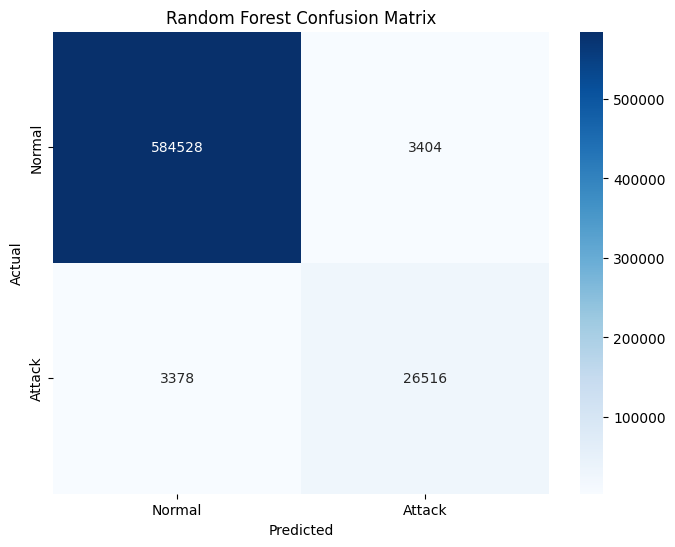

In [40]:
# Visualize confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()